## Using Shallom embeddings for Fr-En Dbpedia

In [1]:
#import scipy as sp
import numpy as np
#import matplotlib.pylab as pl
#from mpl_toolkits.mplot3d import Axes3D  # noqa
#import ot
import pandas as pd
import json
from tqdm import tqdm
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import math
import random
random.seed(1)

In [10]:
path = "Shallom_EnFr_15K_V1"

In [2]:
EnFr_shallom_embs_v1 = pd.read_csv('Shallom_EnFr_15K_V1/Shallom_entity_embeddings.csv')

Fr_shallom_embs_v1 = EnFr_shallom_embs_v1[EnFr_shallom_embs_v1['Unnamed: 0'].apply(lambda x: 'fr.dbpedia.org' in x)]

En_shallom_embs_v1 = EnFr_shallom_embs_v1.iloc[np.setdiff1d(np.arange(EnFr_shallom_embs_v1.shape[0]),\
                                                            np.array(Fr_shallom_embs_v1.index))].set_index('Unnamed: 0')

Fr_shallom_embs_v1 = Fr_shallom_embs_v1.set_index('Unnamed: 0')


In [3]:
with open('OpenEA_dataset_v1.1/EN_FR_15K_V1/ent_links') as file:
    en_to_fr_ents_v1 = file.read().strip().split('\n')
en_to_fr_ents_v1 = dict([line.split('\t') for line in en_to_fr_ents_v1])

with open('OpenEA_dataset_v1.1/EN_FR_15K_V1/721_5fold/1/test_links') as file:
    test_set = file.read().strip().split('\n')
test_set = [line.split('\t')[0] for line in test_set]

In [4]:
def get_source_and_target_matrices(alignment_dict, entity2vec1, entity2vec2, given_test_set=None, emb_dim=200, return_test_set=True):
    """This function takes the dictionary of aligned entities between two KGs and their corresponding embeddings (as entity to vector dictionaries)
    and returns S, T, S_test, T_test, and R defined as follows:
    
    -- S: Subset of the source embeddings, i.e. the matrix of aligned entity embeddings in the first knowledge graph
    
    -- T: Subset of the matrix of aligned entity embeddings in the second knowledge graph
    
    -- S_test and T_test are the embedding matrices corresponding to the lef-out SameAs links
    
    """
    
    if return_test_set:
        assert given_test_set is not None, "given_test_set cannot be None if return_test_set is True"
        test_ents = given_test_set
        train_ents = list(set(alignment_dict.keys())-set(test_ents))
    else:
        train_ents = alignment_dict.keys()
    
    S = np.empty((len(train_ents), emb_dim))
    T = np.empty((len(train_ents), emb_dim))
    if return_test_set:
        S_test = np.empty((len(test_ents), emb_dim))
        T_test = np.empty((len(test_ents), emb_dim))

    for i, key in tqdm(enumerate(train_ents), total=len(train_ents), desc='Computing S and T'):
        S[i] = entity2vec1[key] if isinstance(entity2vec1, dict) else entity2vec1.loc[key].values
        T[i] = entity2vec2[alignment_dict[key]] if isinstance(entity2vec2, dict) else entity2vec2.loc[alignment_dict[key]].values
        
    if return_test_set:
        for i, key in tqdm(enumerate(test_ents), total=len(test_ents), desc='Computing S_test and T_test'):
            S_test[i] = entity2vec1[key] if isinstance(entity2vec1, dict) else entity2vec1.loc[key].values
            T_test[i] = entity2vec2[alignment_dict[key]] if isinstance(entity2vec2, dict) else entity2vec2.loc[alignment_dict[key]].values
    
    if return_test_set:
        return S, T, S_test, T_test
    else:
        return S, T
        

In [5]:
S, T, S_test, T_test = get_source_and_target_matrices(en_to_fr_ents_v1, En_shallom_embs_v1, Fr_shallom_embs_v1, given_test_set=test_set, emb_dim=300)

Computing S_test and T_test: 100%|██████████| 10500/10500 [00:01<00:00, 5703.03it/s]


In [6]:
S, T = torch.FloatTensor(S), torch.FloatTensor(T)

In [7]:
#C1 = sp.spatial.distance.cdist(S, S)
#C2 = sp.spatial.distance.cdist(T, T)
#
#C1 /= C1.max()
#C2 /= C2.max()

In [8]:
#pl.figure()
#pl.subplot(121)
#pl.imshow(C1[:10, :10])
#pl.colorbar()
#pl.subplot(122)
#pl.imshow(C2[:10, :10])
#pl.colorbar()
#pl.show()

In [9]:
#def loss_fun(x, y):
#    return np.abs(x-y)

In [10]:
#p = ot.unif(S.shape[0])
#q = ot.unif(T.shape[0])
#
#t0 = time.time()
##gw0, log0 = ot.gromov.gromov_wasserstein(
##    C1, C2, p, q, 'square_loss', verbose=True, log=True)
#gw0, log0 = ot.gromov.pointwise_gromov_wasserstein(C1, C2, p, q, loss_fun, max_iter=100,
#                                                   log=True)
#gw0 = gw0.toarray()
#print('duration GW: ', time.time()-t0)
#
#t0 = time.time()
##gw, log = ot.gromov.entropic_gromov_wasserstein(
##    C1, C2, p, q, 'square_loss', epsilon=5e-4, log=True, verbose=True)
#gw, log = ot.gromov.sampled_gromov_wasserstein(C1, C2, p, q, loss_fun, epsilon=0.1, max_iter=100,
#                                                   log=True)
#print('duration GW Entropic: ', time.time()-t0)
#
#print('Gromov-Wasserstein distances: ' + str(log0['gw_dist_estimated']))
#print('Entropic Gromov-Wasserstein distances: ' + str(log['gw_dist_estimated']))
#

In [11]:
#pl.figure(1, (10, 5))
#
#pl.subplot(1, 2, 1)
##pl.imshow(gw0, cmap='jet')
#pl.imshow(gw0, cmap='jet')
#pl.title('Gromov Wasserstein')
#
#pl.subplot(1, 2, 2)
##pl.imshow(gw, cmap='jet')
#pl.imshow(gw, cmap='jet')
#pl.title('Entropic Gromov Wasserstein')
#
#pl.show()

In [12]:
#def evaluate_gw(gw, hits=[1, 5, 10]):
#    def hits_k(ranks, k):
#        return (ranks <= k-1).sum()/len(ranks)
#    
#    ids = np.arange(S.shape[0])
#    ranks_ = gw.argsort(1)
#    locs = np.where(ranks_ == ids.reshape(-1,1))[1] # (inverse) ranks of the diagonal elements of gw 
#    ranks = S.shape[0]-locs # ranks of the diagonal elements of gw
#    
#    result = []
#    for k in tqdm(hits):
#        result.append(f"Hits@{k}: "+str(hits_k(ranks, k)))
#    print(', '.join(result))

## Trying to build an efficient network architecture for entity alignment

In [7]:
class MAB(nn.Module):
    def __init__(self, dim_Q, dim_K, dim_V, num_heads, ln=False):
        super(MAB, self).__init__()
        self.dim_V = dim_V
        self.num_heads = num_heads
        self.fc_q = nn.Linear(dim_Q, dim_V)
        self.fc_k = nn.Linear(dim_K, dim_V)
        self.fc_v = nn.Linear(dim_K, dim_V)
        if ln:
            self.ln0 = nn.LayerNorm(dim_V)
            self.ln1 = nn.LayerNorm(dim_V)
        self.fc_o = nn.Linear(dim_V, dim_V)

    def forward(self, Q, K):
        Q = self.fc_q(Q)
        K, V = self.fc_k(K), self.fc_v(K)

        dim_split = self.dim_V // self.num_heads
        Q_ = torch.cat(Q.split(dim_split, 2), 0)
        K_ = torch.cat(K.split(dim_split, 2), 0)
        V_ = torch.cat(V.split(dim_split, 2), 0)

        A = torch.softmax(Q_.bmm(K_.transpose(1,2))/math.sqrt(self.dim_V), 2)
        O = torch.cat((Q_ + A.bmm(V_)).split(Q.size(0), 0), 2)
        O = O if getattr(self, 'ln0', None) is None else self.ln0(O)
        O = O + F.relu(self.fc_o(O))
        O = O if getattr(self, 'ln1', None) is None else self.ln1(O)
        return O

class SAB(nn.Module):
    def __init__(self, dim_in, dim_out, num_heads, ln=False):
        super(SAB, self).__init__()
        self.mab = MAB(dim_in, dim_in, dim_out, num_heads, ln=ln)

    def forward(self, X):
        return self.mab(X, X)

class ISAB(nn.Module):
    def __init__(self, dim_in, dim_out, num_heads, num_inds, ln=False):
        super(ISAB, self).__init__()
        self.I = nn.Parameter(torch.Tensor(1, num_inds, dim_out))
        nn.init.xavier_uniform_(self.I)
        self.mab0 = MAB(dim_out, dim_in, dim_out, num_heads, ln=ln)
        self.mab1 = MAB(dim_in, dim_out, dim_out, num_heads, ln=ln)

    def forward(self, X):
        H = self.mab0(self.I.repeat(X.size(0), 1, 1), X)
        return self.mab1(X, H)

class PMA(nn.Module):
    def __init__(self, dim, num_heads, num_seeds, ln=False):
        super(PMA, self).__init__()
        self.S = nn.Parameter(torch.Tensor(1, num_seeds, dim))
        nn.init.xavier_uniform_(self.S)
        self.mab = MAB(dim, dim, dim, num_heads, ln=ln)

    def forward(self, X):
        return self.mab(self.S.repeat(X.size(0), 1, 1), X)

In [8]:
class SetTransformer(nn.Module):
    def __init__(self, kwargs):
        super(SetTransformer, self).__init__()
        self.name = 'SetTransformer'
        self.enc = nn.Sequential(
                ISAB(kwargs['input_size'], kwargs['proj_dim'], kwargs['num_heads'], kwargs['num_inds'], ln=kwargs['ln']),
                ISAB(kwargs['proj_dim'], kwargs['proj_dim'], kwargs['num_heads'], kwargs['num_inds'], ln=kwargs['ln']))
        
        self.dec = SAB(kwargs['proj_dim'], kwargs['proj_dim'], kwargs['num_heads'], ln=kwargs['ln'])
        
        self.dec_score = nn.Sequential(PMA(kwargs['proj_dim'], kwargs['num_heads'], kwargs['num_seeds'], ln=kwargs['ln']),
                                   nn.Linear(kwargs['proj_dim'], kwargs['output_size']), nn.Sigmoid())
        self.output_size = kwargs["output_size"]
        
    def forward(self, X):
        enc_out = self.enc(X)
        dec_out = self.dec(enc_out)
        scores = self.dec_score(dec_out).reshape(-1, self.output_size)
        return scores, dec_out

In [42]:
class AlignDataSet(torch.utils.data.Dataset):
    def __init__(self, data: list):
        self.Source = data[0]
        self.Target = data[1]
        self.Label = data[2]
        super(AlignDataSet, self).__init__()
        
    def __len__(self):
        return len(self.Source)
    
    def __getitem__(self, idx):
        source = self.Source[idx]
        target = self.Target[idx]
        return pad_sequence([source, target], batch_first=True, padding_value=0), self.Label[idx]

In [33]:
def train(model, train_dataset, epochs, loss, num_workers=8, batch_size=128, lr=0.0001):
    import copy
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    best_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for e in range(epochs):
        Acc = 0.0
        for x, y in tqdm(train_dataloader):
            scores, hidden = model(x)
            loss_val = loss(scores, y)
            Acc += (y==scores.argmax(1)).sum()
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
        print(f"Epoch {e} ... Loss: {loss_val.item()}, Acc: {Acc/len(train_dataset)}")
        if Acc > best_acc:
            best_acc = Acc
            best_weights = copy.deepcopy(model.state_dict())
    model.load_state_dict(best_weights)
    torch.save(model, f"{path}/SetTransformer_{round(best_acc.item(), 2)}.pt")

In [45]:
def test(model, test_dataset, num_workers=8, batch_size=128):
    model.eval()
    Acc = 0.0
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
    for x, y in tqdm(test_dataloader):
        score, hidden = model(x)
        Acc += (score.argmax(1)==y).sum().item()
    print("Test acc: ", Acc/len(test_dataset))

In [21]:
def generate_false_matching(data):
    corrupted_data = []
    source, target = torch.empty(len(data[0]), data[0].shape[1]), torch.empty(len(data[0]), data[0].shape[1])
    all_idx = set(range(len(data[0])))
    for i in range(len(data[0])):
        candidate_idx = list(all_idx-{i})
        idx = random.choice(candidate_idx)
        source[i] = data[0][i]
        target[i] = data[1][idx]
    return source, target

In [22]:
corrupt_source, corrupt_target = generate_false_matching([S,T])

In [23]:
labels = torch.cat([torch.ones(corrupt_source.shape[0]), torch.zeros(corrupt_source.shape[0])], 0).to(torch.long)

In [24]:
source, target = torch.cat([S, corrupt_source], 0), torch.cat([T, corrupt_target], 0)

In [25]:
data = [source, target, labels]

In [26]:
train_dataset = AlignDataSet(data)

In [27]:
kwargs = {"input_size": 300, "proj_dim": 128, "num_heads": 4, "num_inds": 32, "num_seeds": 1, "ln": False, "output_size": 2}

In [28]:
model = SetTransformer(kwargs)

In [29]:
loss = nn.CrossEntropyLoss()

In [30]:
train(model, train_dataset, epochs=50, loss=loss, lr=0.0003)

100%|██████████| 71/71 [00:15<00:00,  4.50it/s]


Epoch 0 ... Loss: 0.7186356782913208, Acc: 0.5106666684150696


100%|██████████| 71/71 [00:15<00:00,  4.57it/s]


Epoch 1 ... Loss: 0.6512174010276794, Acc: 0.5827777981758118


100%|██████████| 71/71 [00:15<00:00,  4.65it/s]


Epoch 2 ... Loss: 0.5707482099533081, Acc: 0.7073333263397217


100%|██████████| 71/71 [00:15<00:00,  4.58it/s]


Epoch 3 ... Loss: 0.6459649801254272, Acc: 0.742111086845398


100%|██████████| 71/71 [00:14<00:00,  4.97it/s]


Epoch 4 ... Loss: 0.5666635036468506, Acc: 0.7632222175598145


100%|██████████| 71/71 [00:15<00:00,  4.71it/s]


Epoch 5 ... Loss: 0.5170491933822632, Acc: 0.7873333096504211


100%|██████████| 71/71 [00:16<00:00,  4.29it/s]


Epoch 6 ... Loss: 0.6000741720199585, Acc: 0.8013333082199097


100%|██████████| 71/71 [00:15<00:00,  4.45it/s]


Epoch 7 ... Loss: 0.491852343082428, Acc: 0.820888876914978


100%|██████████| 71/71 [00:14<00:00,  4.73it/s]


Epoch 8 ... Loss: 0.4250366687774658, Acc: 0.8206666707992554


100%|██████████| 71/71 [00:16<00:00,  4.31it/s]


Epoch 9 ... Loss: 0.39465102553367615, Acc: 0.8374444246292114


100%|██████████| 71/71 [00:16<00:00,  4.21it/s]


Epoch 10 ... Loss: 0.5241919159889221, Acc: 0.8386666774749756


100%|██████████| 71/71 [00:17<00:00,  3.99it/s]


Epoch 11 ... Loss: 0.5331332683563232, Acc: 0.8487777709960938


100%|██████████| 71/71 [00:17<00:00,  4.09it/s]


Epoch 12 ... Loss: 0.5322104096412659, Acc: 0.8572221994400024


100%|██████████| 71/71 [00:20<00:00,  3.45it/s]


Epoch 13 ... Loss: 0.462246835231781, Acc: 0.8572221994400024


100%|██████████| 71/71 [00:19<00:00,  3.67it/s]


Epoch 14 ... Loss: 0.5415084958076477, Acc: 0.8597777485847473


100%|██████████| 71/71 [00:19<00:00,  3.69it/s]


Epoch 15 ... Loss: 0.5274215340614319, Acc: 0.8658888936042786


100%|██████████| 71/71 [00:22<00:00,  3.12it/s]


Epoch 16 ... Loss: 0.4960044026374817, Acc: 0.874666690826416


100%|██████████| 71/71 [00:24<00:00,  2.91it/s]


Epoch 17 ... Loss: 0.38333410024642944, Acc: 0.8784444332122803


100%|██████████| 71/71 [00:22<00:00,  3.13it/s]


Epoch 18 ... Loss: 0.3746541142463684, Acc: 0.8803333044052124


100%|██████████| 71/71 [00:20<00:00,  3.41it/s]


Epoch 19 ... Loss: 0.4960826337337494, Acc: 0.8845555782318115


100%|██████████| 71/71 [00:21<00:00,  3.31it/s]


Epoch 20 ... Loss: 0.5169781446456909, Acc: 0.886888861656189


100%|██████████| 71/71 [00:20<00:00,  3.41it/s]


Epoch 21 ... Loss: 0.5070103406906128, Acc: 0.8901110887527466


100%|██████████| 71/71 [00:22<00:00,  3.14it/s]


Epoch 22 ... Loss: 0.4139432907104492, Acc: 0.8881111145019531


100%|██████████| 71/71 [00:24<00:00,  2.88it/s]


Epoch 23 ... Loss: 0.4383591115474701, Acc: 0.8790000081062317


100%|██████████| 71/71 [00:22<00:00,  3.14it/s]


Epoch 24 ... Loss: 0.3699967861175537, Acc: 0.8912222385406494


100%|██████████| 71/71 [00:21<00:00,  3.30it/s]


Epoch 25 ... Loss: 0.41343212127685547, Acc: 0.8964444398880005


100%|██████████| 71/71 [00:22<00:00,  3.12it/s]


Epoch 26 ... Loss: 0.4459921419620514, Acc: 0.9007777571678162


100%|██████████| 71/71 [00:20<00:00,  3.45it/s]


Epoch 27 ... Loss: 0.4134364128112793, Acc: 0.9012222290039062


100%|██████████| 71/71 [00:20<00:00,  3.49it/s]


Epoch 28 ... Loss: 0.375165194272995, Acc: 0.8923333287239075


100%|██████████| 71/71 [00:22<00:00,  3.14it/s]


Epoch 29 ... Loss: 0.3222988247871399, Acc: 0.8901110887527466


100%|██████████| 71/71 [00:23<00:00,  3.05it/s]


Epoch 30 ... Loss: 0.3929559588432312, Acc: 0.8954444527626038


100%|██████████| 71/71 [00:23<00:00,  2.99it/s]


Epoch 31 ... Loss: 0.3883630931377411, Acc: 0.9006666541099548


100%|██████████| 71/71 [00:24<00:00,  2.93it/s]


Epoch 32 ... Loss: 0.35054296255111694, Acc: 0.9024444222450256


100%|██████████| 71/71 [00:22<00:00,  3.17it/s]


Epoch 33 ... Loss: 0.440331369638443, Acc: 0.9043333530426025


100%|██████████| 71/71 [00:25<00:00,  2.77it/s]


Epoch 34 ... Loss: 0.3911030888557434, Acc: 0.9046666622161865


100%|██████████| 71/71 [00:25<00:00,  2.77it/s]


Epoch 35 ... Loss: 0.33849066495895386, Acc: 0.907444417476654


100%|██████████| 71/71 [00:22<00:00,  3.14it/s]


Epoch 36 ... Loss: 0.38889169692993164, Acc: 0.9116666913032532


100%|██████████| 71/71 [00:22<00:00,  3.15it/s]


Epoch 37 ... Loss: 0.4707370698451996, Acc: 0.9095555543899536


100%|██████████| 71/71 [00:22<00:00,  3.22it/s]


Epoch 38 ... Loss: 0.37806442379951477, Acc: 0.910111129283905


100%|██████████| 71/71 [00:25<00:00,  2.79it/s]


Epoch 39 ... Loss: 0.38895100355148315, Acc: 0.9126666784286499


100%|██████████| 71/71 [00:24<00:00,  2.94it/s]


Epoch 40 ... Loss: 0.36179596185684204, Acc: 0.9114444255828857


100%|██████████| 71/71 [00:23<00:00,  2.98it/s]


Epoch 41 ... Loss: 0.42263928055763245, Acc: 0.9057777523994446


100%|██████████| 71/71 [00:24<00:00,  2.94it/s]


Epoch 42 ... Loss: 0.3132622241973877, Acc: 0.913777768611908


100%|██████████| 71/71 [00:22<00:00,  3.20it/s]


Epoch 43 ... Loss: 0.36324864625930786, Acc: 0.9190000295639038


100%|██████████| 71/71 [00:23<00:00,  3.02it/s]


Epoch 44 ... Loss: 0.3394232392311096, Acc: 0.9198889136314392


100%|██████████| 71/71 [00:21<00:00,  3.26it/s]


Epoch 45 ... Loss: 0.4632341265678406, Acc: 0.918666660785675


100%|██████████| 71/71 [00:24<00:00,  2.90it/s]


Epoch 46 ... Loss: 0.3633319139480591, Acc: 0.9150000214576721


100%|██████████| 71/71 [00:26<00:00,  2.65it/s]


Epoch 47 ... Loss: 0.36344391107559204, Acc: 0.9166666865348816


100%|██████████| 71/71 [00:26<00:00,  2.72it/s]


Epoch 48 ... Loss: 0.43465057015419006, Acc: 0.9155555367469788


100%|██████████| 71/71 [00:27<00:00,  2.55it/s]

Epoch 49 ... Loss: 0.3132687211036682, Acc: 0.9154444336891174


TypeError: type Tensor doesn't define __round__ method

In [37]:
S_test, T_test = torch.FloatTensor(S_test), torch.FloatTensor(T_test)

In [38]:
test_labels = torch.ones(S_test.shape[0])

In [43]:
data_test = [S_test, T_test, test_labels]

test_dataset = AlignDataSet(data_test)

In [46]:
test(model, test_dataset)

100%|██████████| 83/83 [00:02<00:00, 27.99it/s]

Test acc:  0.8485714285714285


<font color='blue'> ~85% accuracy on the test data !!! </font>

# The experiments with SetTransformer have finished here. Cells below are old implementations with the Procrustes approach!

## Fr-En Dbpedia 100K V2

In [20]:
EnFr_shallom_embs_v2 = pd.read_csv('Shallom_EnFr_100K_V2/Shallom_entity_embeddings.csv')

In [21]:
Fr_shallom_embs_v2 = EnFr_shallom_embs_v2[EnFr_shallom_embs_v2['Unnamed: 0'].apply(lambda x: 'fr.dbpedia.org' in x)]

In [22]:
En_shallom_embs_v2 = EnFr_shallom_embs_v2.iloc[np.setdiff1d(np.arange(EnFr_shallom_embs_v2.shape[0]),\
                                                            np.array(Fr_shallom_embs_v2.index))].set_index('Unnamed: 0')

In [23]:
Fr_shallom_embs_v2 = Fr_shallom_embs_v2.set_index('Unnamed: 0')

In [24]:
En_shallom_embs_v2.head(3)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
http://dbpedia.org/resource/Sailing_to_Philadelphia,-0.107208,-0.463760,0.234986,-0.300843,-0.297771,0.157350,0.063645,0.219653,-0.373847,-0.517257,...,0.067203,-0.013326,0.009563,0.097662,-0.050666,0.292337,-0.091069,0.141930,0.412293,0.111441
http://dbpedia.org/resource/Horde_(band),-0.031448,0.542308,0.141856,-0.131928,-0.129672,0.056684,0.103640,0.017796,-0.080704,-0.920316,...,0.044921,0.069479,0.162442,0.144002,-0.108662,-0.412152,0.096725,0.008034,-0.273330,-0.185328
http://dbpedia.org/resource/Nessbeal,0.199559,-0.110438,0.225365,-0.145648,0.400099,-0.134547,0.287914,0.045707,0.731766,0.462888,...,0.217795,-0.313416,-0.295566,-0.239344,0.248340,0.115179,-0.185138,0.092450,-0.689202,0.140009


In [25]:
with open('OpenEA_dataset_v1.1/EN_FR_100K_V2/ent_links') as file:
    en_to_fr_ents_v2 = file.read().strip().split('\n')
en_to_fr_ents_v2 = dict([line.split('\t') for line in en_to_fr_ents_v2])

In [26]:
with open('OpenEA_dataset_v1.1/EN_FR_100K_V2/721_5fold/1/test_links') as file:
    test_set = file.read().strip().split('\n')
test_set = [line.split('\t')[0] for line in test_set]

In [35]:
_, _, _, _, _, _, S_test, T_test, R = get_source_and_target_matrices(en_to_fr_ents_v2,\
                                                En_shallom_embs_v2, Fr_shallom_embs_v2, given_test_set=test_set, emb_dim=300, test_size=0.2, shift=False, scale=False)

Computing S_eval and T_eval: 100%|██████████| 70000/70000 [00:12<00:00, 5533.71it/s]



Now computing R...
Scale S:  6.116433867944566

Completed after 18.63508653640747 seconds
Alignment loss:  298776.82671862666


In [2]:
evaluate_alignment_knn(S_test, T_test, R, assume_known=True, hit_values=[1, 5, 10])

In [14]:
scale_S, scale_T, mean_S, mean_T, S, T, R = get_source_and_target_matrices(en_to_fr_ents_v2,\
                                                                                    En_shallom_embs_v2, Fr_shallom_embs_v2, emb_dim=300, test_size=0.0)

Computing S and T: 100%|██████████| 100000/100000 [00:19<00:00, 5137.75it/s]



Now computing R...
Scale S:  6.113047898546291

Completed after 0.695664644241333 seconds
Alignment loss:  28446.94522432553


In [15]:
A_neg_S, B_neg_T = get_non_aligned_entity_embedding_matrices(en_to_fr_ents_v2, En_shallom_embs_v2, \
                                                             Fr_shallom_embs_v2, scale_S, scale_T, mean_S, mean_T, emb_dim=300)

Computing A_neg_S...: 0it [00:00, ?it/s]
Computing B_neg_T...: 0it [00:00, ?it/s]


In [16]:
# compute every s_i as (s_i@R+t_i)/2
S = (S@R + T)/2
del T
gc.collect()
Universal_Emb = np.concatenate([A_neg_S@R, B_neg_T, S], axis=0)

In [17]:
np.save('Shallom_EnFr_100K_V2/Universal_Emb.npy', Universal_Emb)

In [18]:
list_merged_entities = sorted(set(En_shallom_embs_v2.index)-set(en_to_fr_ents_v2.keys())) +\
sorted(set(Fr_shallom_embs_v2.index)-set(en_to_fr_ents_v2.values())) + \
list(en_to_fr_ents_v2.keys())
print('Total: ', len(list_merged_entities))
with open('Shallom_EnFr_100K_V2/list_merged_entities_db_fr_en.txt', 'w') as file:
    file.write('\t'.join(list_merged_entities))
del list_merged_entities

Total:  100000


In [38]:
with open('Shallom_EnFr_100K_V2/english2french.json', 'w') as file:
    json.dump(en_to_fr_ents_v2, file, ensure_ascii=False)

## Deutsch and English DBpedia

In [1]:
import torch, pandas as pd
import json
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.spatial import procrustes
from scipy.linalg import orthogonal_procrustes
import time, gc
from sklearn.neighbors import NearestNeighbors
import random
from tqdm import tqdm
gc.enable()
random.seed(42)

In [2]:
def get_source_and_target_matrices(alignment_dict, entity2vec1, entity2vec2, given_test_set=None, emb_dim=200, return_test_set=True):
    """This function takes the dictionary of aligned entities between two KGs and their corresponding embeddings (as entity to vector dictionaries)
    and returns S, T, S_test, T_test, and R defined as follows:
    
    -- S: Subset of the source embeddings, i.e. the matrix of aligned entity embeddings in the first knowledge graph
    
    -- T: Subset of the matrix of aligned entity embeddings in the second knowledge graph
    
    -- S_test and T_test are the embedding matrices corresponding to the lef-out SameAs links
    
    """
    
    if return_test_set:
        assert given_test_set is not None, "given_test_set cannot be None if return_test_set is True"
        test_ents = given_test_set
        train_ents = list(set(alignment_dict.keys())-set(test_ents))
    else:
        train_ents = alignment_dict.keys()
    
    S = np.empty((len(train_ents), emb_dim))
    T = np.empty((len(train_ents), emb_dim))
    if return_test_set:
        S_test = np.empty((len(test_ents), emb_dim))
        T_test = np.empty((len(test_ents), emb_dim))

    for i, key in tqdm(enumerate(train_ents), total=len(train_ents), desc='Computing S and T'):
        S[i] = entity2vec1[key] if isinstance(entity2vec1, dict) else entity2vec1.loc[key].values
        T[i] = entity2vec2[alignment_dict[key]] if isinstance(entity2vec2, dict) else entity2vec2.loc[alignment_dict[key]].values
        
    if return_test_set:
        for i, key in tqdm(enumerate(test_ents), total=len(test_ents), desc='Computing S_test and T_test'):
            S_test[i] = entity2vec1[key] if isinstance(entity2vec1, dict) else entity2vec1.loc[key].values
            T_test[i] = entity2vec2[alignment_dict[key]] if isinstance(entity2vec2, dict) else entity2vec2.loc[alignment_dict[key]].values
    
    if return_test_set:
        return S, T, S_test, T_test
    else:
        return S, T
        

In [3]:
def get_non_aligned_entity_embedding_matrices(alignment_dict, entity2vec1, entity2vec2, scale_S, scale_T, mean_S, mean_T, emb_dim=200):
    """
    Inputs the dictionary of aligned entities between two KGs and their corresponding embeddings, and returns the normalized embedding matrices of 
    
    non-aligned entities
    """
    A_neg_S = np.empty((len(entity2vec1)-len(alignment_dict), emb_dim))
    keys = sorted(set(entity2vec1.keys() if isinstance(entity2vec1, dict) else entity2vec1.index)-set(alignment_dict.keys()))
    for i, key in tqdm(enumerate(keys), total=A_neg_S.shape[0], desc='Computing A_neg_S...'):
        A_neg_S[i] = entity2vec1[key] if isinstance(entity2vec1, dict) else entity2vec1.loc[key].values
    
    B_neg_T = np.empty((len(entity2vec2)-len(alignment_dict), emb_dim))
    keys = sorted(set(entity2vec2.keys() if isinstance(entity2vec2, dict) else entity2vec2.index)-set(alignment_dict.values()))
    for i, key in tqdm(enumerate(keys), total=B_neg_T.shape[0], desc='Computing B_neg_T...'):
        B_neg_T[i] = entity2vec2[key] if isinstance(entity2vec2, dict) else entity2vec2.loc[key].values
        
    return (A_neg_S-mean_S)/scale_S, (B_neg_T-mean_T)/scale_T
    

In [4]:
def evaluate_alignment_knn(S_test, T_test, R, assume_known=False, hit_values = [1, 3, 10], rotate=True):
    """The function takes the evaluation sets, i.e. correct alignments that were left out, and returns the hits@ and MRR results w.r.t. correct alignments
    
    --assume_known. A boolean variable. When set to True, the alignment results are computed using the fact that the test links are known
    
    """
    print('#'*50)
    print('Evaluation started...')
    print('#'*50)
    model = NearestNeighbors(n_neighbors=S_test.shape[0], n_jobs=-1)
    print('Fitting 1...')
    model.fit(T_test)
    print('Predicting 1...')
    if assume_known:
        if rotate:
            preds = model.kneighbors((S_test@R+T_test)/2, n_neighbors=S_test.shape[0], return_distance=False)
        else:
            preds = model.kneighbors((S_test+T_test)/2, n_neighbors=S_test.shape[0], return_distance=False)
    else:
        if rotate:
            preds = model.kneighbors(S_test@R, n_neighbors=S_test.shape[0], return_distance=False)
        else:
            preds = model.kneighbors(S_test, n_neighbors=S_test.shape[0], return_distance=False)
    Hits1 = np.zeros(len(hit_values))
    MRR1 = 0.0
    for i in tqdm(range(S_test.shape[0]), total=S_test.shape[0]):
        pred_idx = (preds[i]==i).nonzero()[0][0] # if i in preds[i] else S_test.shape[0]
        MRR1 += (1./(pred_idx+1))
        for j in range(len(Hits1)):
            if pred_idx < hit_values[j]:
                Hits1[j] += 1.0/S_test.shape[0]
    MRR1 = MRR1/S_test.shape[0]
    
    model = NearestNeighbors(n_neighbors=S_test.shape[0], n_jobs=-1)
    print('\nFitting 2...')
    if assume_known:
        if rotate:
            model.fit((S_test@R+T_test)/2)
        else:
            model.fit((S_test+T_test)/2)
    else:
        if rotate:
            model.fit(S_test@R)
        else:
            model.fit(S_test)
    print('Predicting 2...')
    preds = model.kneighbors(T_test, n_neighbors=S_test.shape[0], return_distance=False)
    Hits2 = np.zeros(len(hit_values))
    MRR2 = 0.0
    for i in tqdm(range(S_test.shape[0]), total=S_test.shape[0]):
        pred_idx = (preds[i]==i).nonzero()[0][0] # if i in preds[i] else S_test.shape[0]
        MRR2 += (1./(pred_idx+1))
        for j in range(len(Hits2)):
            if pred_idx < hit_values[j]:
                Hits2[j] += 1.0/S_test.shape[0]
    MRR2 = MRR2/S_test.shape[0]
    
    Hits = (Hits1+Hits2)/2
    MRR = (MRR1+MRR2)/2
    print()
    print(', '.join([f'Hits@{hit_values[it]}: {Hits[it]}' for it in range(len(Hits))]+[f'MRR: {MRR}']))

In [6]:
def export_to_csv(path):
    import torch
    import dask.dataframe as dd
    entity_embeddings=torch.load(f'{path}/Shallom_entity_embeddings.pt').detach().numpy()
    entity_to_idx = dd.read_parquet(f'{path}/entity_to_idx.gzip').compute()
    df = dd.from_array(entity_embeddings).compute()
    df=df.set_index(entity_to_idx.index)
    df.head()
    df.to_csv(f'{path}/Shallom_entity_embeddings.csv')

In [7]:
for path in ["Experiments/EN_DE_15K_V1", "Experiments/EN_DE_15K_V2", "Experiments/EN_DE_100K_V1", "Experiments/EN_DE_100K_V2"]:
    export_to_csv(path)

### 15k v1

In [8]:
EnDe_shallom_embs = pd.read_csv('Experiments/EN_DE_15K_V1/Shallom_entity_embeddings.csv')

De_shallom_embs = EnDe_shallom_embs[EnDe_shallom_embs['Unnamed: 0'].apply(lambda x: 'de.dbpedia.org' in x)]

En_shallom_embs = EnDe_shallom_embs.iloc[np.setdiff1d(np.arange(EnDe_shallom_embs.shape[0]),\
                                                            np.array(De_shallom_embs.index))].set_index('Unnamed: 0')

De_shallom_embs = De_shallom_embs.set_index('Unnamed: 0')

with open('OpenEA_dataset_v1.1/EN_DE_15K_V1/ent_links') as file:
    en_to_de_ents = file.read().strip().split('\n')
en_to_de_ents = dict([line.split('\t') for line in en_to_de_ents])

with open('OpenEA_dataset_v1.1/EN_DE_15K_V1/721_5fold/1/test_links') as file:
    test_set = file.read().strip().split('\n')
test_set = [line.split('\t')[0] for line in test_set]


In [9]:
De_shallom_embs.shape

(15000, 300)

In [44]:
_, _, _, _, _, _, S_test, T_test, R = get_source_and_target_matrices(en_to_de_ents,\
                                                En_shallom_embs, De_shallom_embs, given_test_set=test_set, emb_dim=300, test_size=0.2, scale=False, shift=False)

evaluate_alignment_knn(S_test, T_test, R, assume_known=True, hit_values=[1, 5, 10])

Computing S_eval and T_eval: 100%|██████████| 10500/10500 [00:01<00:00, 5479.53it/s]



Now computing R...
Scale S:  0.05050015345675206

Completed after 3.037355422973633 seconds
Alignment loss:  7.813596754606659
##################################################
Evaluation started...
##################################################
Fitting 1...
Predicting 1...


100%|██████████| 10500/10500 [00:00<00:00, 45059.44it/s]



Fitting 2...
Predicting 2...


100%|██████████| 10500/10500 [00:00<00:00, 44068.35it/s]


Hits@1: 0.41747619047618023, Hits@5: 0.5862380952381306, Hits@10: 0.6490952380953084, MRR: 0.49776320692690734


## 15k v2

In [125]:
EnDe_shallom_embs = pd.read_csv('Experiments/EN_DE_15K_V2/Shallom_entity_embeddings.csv')

De_shallom_embs = EnDe_shallom_embs[EnDe_shallom_embs['Unnamed: 0'].apply(lambda x: 'de.dbpedia.org' in x)]

En_shallom_embs = EnDe_shallom_embs.iloc[np.setdiff1d(np.arange(EnDe_shallom_embs.shape[0]),\
                                                            np.array(De_shallom_embs.index))].set_index('Unnamed: 0')

De_shallom_embs = De_shallom_embs.set_index('Unnamed: 0')

with open('OpenEA_dataset_v1.1/EN_DE_15K_V2/ent_links') as file:
    en_to_de_ents = file.read().strip().split('\n')
en_to_de_ents = dict([line.split('\t') for line in en_to_de_ents])

with open('OpenEA_dataset_v1.1/EN_DE_15K_V2/721_5fold/1/test_links') as file:
    test_set = file.read().strip().split('\n')
test_set = [line.split('\t')[0] for line in test_set]


In [128]:
_, _, _, _, _, _, S_test, T_test, R = get_source_and_target_matrices(en_to_de_ents,\
                                                En_shallom_embs, De_shallom_embs, given_test_set=test_set, emb_dim=300, test_size=0.2, scale=False, shift=False)

evaluate_alignment_knn(S_test, T_test, R, assume_known=True, hit_values=[1, 5, 10])

Computing S_eval and T_eval: 100%|██████████| 10500/10500 [00:01<00:00, 5406.62it/s]



Now computing R...
Scale S:  0.04797353058639573

Completed after 0.21141839027404785 seconds
Alignment loss:  7.12450207466435
##################################################
Evaluation started...
##################################################
Fitting 1...
Predicting 1...


100%|██████████| 10500/10500 [00:00<00:00, 46697.61it/s]



Fitting 2...
Predicting 2...


100%|██████████| 10500/10500 [00:00<00:00, 45976.64it/s]


Hits@1: 0.46542857142857996, Hits@5: 0.6234285714286275, Hits@10: 0.6857619047619955, MRR: 0.5412170755634034


### 100k v1

In [8]:
EnDe_shallom_embs = pd.read_csv('Experiments/EN_DE_100K_V1/Shallom_entity_embeddings.csv')

De_shallom_embs = EnDe_shallom_embs[EnDe_shallom_embs['Unnamed: 0'].apply(lambda x: 'de.dbpedia.org' in x)]

En_shallom_embs = EnDe_shallom_embs.iloc[np.setdiff1d(np.arange(EnDe_shallom_embs.shape[0]),\
                                                            np.array(De_shallom_embs.index))].set_index('Unnamed: 0')

De_shallom_embs = De_shallom_embs.set_index('Unnamed: 0')

with open('OpenEA_dataset_v1.1/EN_DE_100K_V1/ent_links') as file:
    en_to_de_ents = file.read().strip().split('\n')
en_to_de_ents = dict([line.split('\t') for line in en_to_de_ents])

with open('OpenEA_dataset_v1.1/EN_DE_100K_V1/721_5fold/1/test_links') as file:
    test_set = file.read().strip().split('\n')
test_set = [line.split('\t')[0] for line in test_set]


In [10]:
_, _, _, _, _, _, S_test, T_test, R = get_source_and_target_matrices(en_to_de_ents,\
                                                En_shallom_embs, De_shallom_embs, given_test_set=test_set, emb_dim=300, test_size=0.2, shift=False, scale=False)

evaluate_alignment_knn(S_test, T_test, R, assume_known=True, hit_values=[1, 5, 10])

Computing S_eval and T_eval: 100%|██████████| 70000/70000 [00:12<00:00, 5598.68it/s]



Now computing R...
Scale S:  0.021902208641113658

Completed after 18.421804189682007 seconds
Alignment loss:  8.544725213632967
##################################################
Evaluation started...
##################################################
Fitting 1...
Predicting 1...


100%|██████████| 70000/70000 [00:06<00:00, 11287.51it/s]



Fitting 2...
Predicting 2...


100%|██████████| 70000/70000 [00:06<00:00, 10155.74it/s]


Hits@1: 0.2834999999999413, Hits@5: 0.4085714285711827, Hits@10: 0.46552857142828574, MRR: 0.3456914632419348


In [9]:
scale_S, scale_T, mean_S, mean_T, S, T, R = get_source_and_target_matrices(en_to_de_ents,\
                                                En_shallom_embs, De_shallom_embs, given_test_set=test_set, emb_dim=300, test_size=0.0)

Computing S and T: 100%|██████████| 100000/100000 [00:18<00:00, 5528.14it/s]



Now computing R...
Scale S:  0.021967541711728614

Completed after 19.402446746826172 seconds
Alignment loss:  62694.90656351184


In [10]:
# compute every s_i as (s_i@R+t_i)/2
S = (S@R + T)/2
del T
gc.collect()

0

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument("--es_index", nargs='+', type=str, default=["DBP_EN_FR_15K", "DBP_EN_FR_100K", "DBP_EN_DE_100K"], \
                    help="Preferred dataset name on Elastic Search")
parser.add_argument("--data_folder", nargs='+', type=str, default=["Shallom_EnFr_15K_V1/", "Shallom_EnFr_100K_V1/", "Experiments/EN_DE_100K_V1/"],\
                   help="Names of folders where universal embeddings are located")
parser.add_argument("--max_docs", type=int, default=10000, help="Batch size of documents to upload")
parser.add_argument("--password", type=str, default=None, help="Password to upload or delete data")

In [11]:
np.save('Experiments/EN_DE_100K_V1//Universal_Emb.npy', S)

In [12]:
with open('Experiments/EN_DE_100K_V1/list_merged_entities_db_en_de.txt', 'w') as file:
    file.write('\t'.join(en_to_de_ents))

In [13]:
with open('Experiments/EN_DE_100K_V1/english2german.json', 'w') as file:
    json.dump(en_to_de_ents, file, ensure_ascii=False)

### 100k v2

In [5]:
EnDe_shallom_embs = pd.read_csv('Experiments/EN_DE_100K_V2/Shallom_entity_embeddings.csv')

De_shallom_embs = EnDe_shallom_embs[EnDe_shallom_embs['Unnamed: 0'].apply(lambda x: 'de.dbpedia.org' in x)]

En_shallom_embs = EnDe_shallom_embs.iloc[np.setdiff1d(np.arange(EnDe_shallom_embs.shape[0]),\
                                                            np.array(De_shallom_embs.index))].set_index('Unnamed: 0')
De_shallom_embs = De_shallom_embs.set_index('Unnamed: 0')

with open('OpenEA_dataset_v1.1/EN_DE_100K_V2/ent_links') as file:
    en_to_de_ents = file.read().strip().split('\n')
en_to_de_ents = dict([line.split('\t') for line in en_to_de_ents])

with open('OpenEA_dataset_v1.1/EN_DE_100K_V2/721_5fold/1/test_links') as file:
    test_set = file.read().strip().split('\n')
test_set = [line.split('\t')[0] for line in test_set]


In [13]:
_, _, _, _, _, _, S_test, T_test, R = get_source_and_target_matrices(en_to_de_ents,\
                                                En_shallom_embs, De_shallom_embs, given_test_set=test_set, emb_dim=300, test_size=0.2, shift=False, scale=False)

evaluate_alignment_knn(S_test, T_test, R, assume_known=True, hit_values=[1, 5, 10])

Computing S_eval and T_eval: 100%|██████████| 70000/70000 [00:13<00:00, 5180.54it/s]



Now computing R...
Scale S:  0.02760568790057487

Completed after 19.92166757583618 seconds
Alignment loss:  14.747715207779663
##################################################
Evaluation started...
##################################################
Fitting 1...
Predicting 1...


100%|██████████| 70000/70000 [00:06<00:00, 11384.53it/s]



Fitting 2...
Predicting 2...


100%|██████████| 70000/70000 [00:12<00:00, 5568.78it/s] 


Hits@1: 0.49427142857128803, Hits@5: 0.6583214285713545, Hits@10: 0.7198214285714842, MRR: 0.5721232082416863


### Scalability

In [28]:
import matplotlib.pyplot as plt

In [29]:
time = [[4.3, 8.3, 12.9, 17.1], [329, 300.6], [350.8, 1084.5]]
MRR = [[0.47, 0.43, 0.29, 0.40], [0.35, 0.33], [0.04, 0.04]]
x_axis = ["50K", "100K", "150K", "200K"]

Text(0, 0.5, 'Training time')

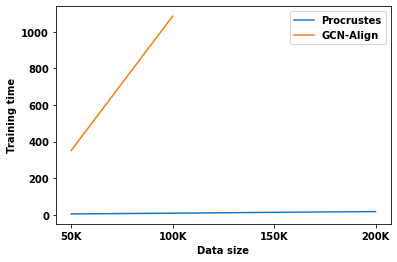

In [40]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.plot(x_axis, time[0])
#plt.plot(x_axis[:2], time[1])
plt.plot(x_axis[:2], time[2])
plt.legend(("Procrustes", "GCN-Align"))
plt.xlabel("Data size")
plt.ylabel("Training time")

In [ ]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.plot(x_axis, time[0])
#plt.plot(x_axis[:2], time[1])
plt.plot(x_axis[:2], time[2])
plt.legend(("Procrustes", "GCN-Align"))
plt.xlabel("Data size")
plt.ylabel("Training time")